# Stacked LSTMs with Memory Between Batches

LSTM adalah salah satu jenis dari jaringan saraf rekuren (Recurrent Neural Network atau RNN) yang dirancang untuk mengatasi masalah "vanishing gradient" yang sering terjadi dalam jaringan saraf rekuren konvensional.

berbeda dengan neural network yang menggunakan neuron seperti umumnya

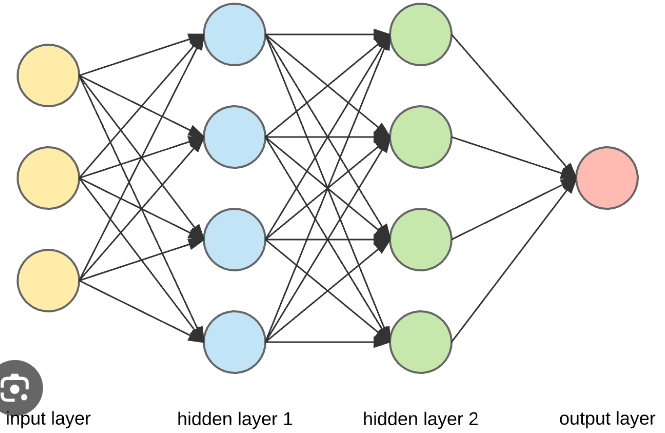

 LSTM menggunakan memory block pada masing-masing layer

Berikut merupakan struktur dari LSTM:

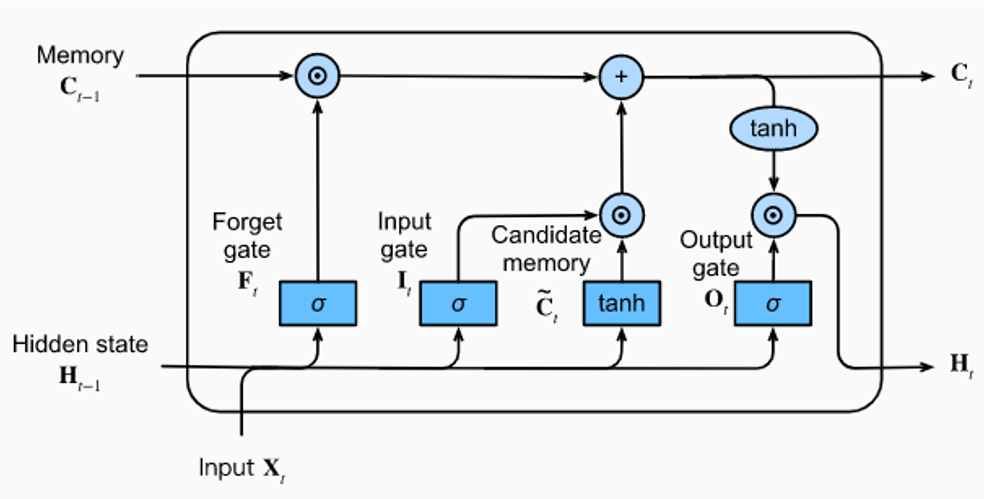

1. Input Gate:

Input gate mengontrol seberapa banyak informasi baru akan diintegrasikan ke dalam cell state.
Ini melibatkan fungsi aktivasi sigmoid yang mengambil input dari input data dan hidden state pada langkah sebelumnya.
Hasil sigmoid mengindikasikan sejauh mana setiap elemen informasi baru akan dimasukkan ke dalam cell state.

2. Forget Gate:

Forget gate menentukan sejauh mana informasi dari cell state sebelumnya akan dijaga atau dilupakan.
Ini juga menggunakan fungsi aktivasi sigmoid yang mengambil input dari input data dan hidden state sebelumnya.
Hasil sigmoid mengindikasikan sejauh mana elemen-elemen cell state sebelumnya akan dihilangkan atau dipertahankan.

3. Cell State:

Cell state adalah komponen internal LSTM yang menyimpan informasi dalam jangka waktu yang panjang.
Informasi baru ditambahkan ke cell state melalui input gate dan informasi lama dihapus atau dipertahankan melalui forget gate.
Ini adalah komponen utama yang memungkinkan LSTM untuk mengingat informasi jangka panjang.

4. Output Gate:

Output gate mengatur sejauh mana cell state saat ini akan memengaruhi hidden state dan output model.
Ini melibatkan fungsi aktivasi sigmoid yang mengambil input dari input data dan hidden state sebelumnya serta cell state saat ini.
Hasil sigmoid mengontrol berapa banyak informasi dalam cell state yang akan disalurkan ke hidden state dan output model.

5. Hidden State:

Hidden state adalah keluaran aktual dari LSTM pada suatu langkah waktu tertentu.
Ini mencerminkan informasi yang telah diproses oleh LSTM pada langkah waktu sebelumnya dan informasi dari cell state saat ini.
Hidden state juga dapat digunakan sebagai input untuk langkah waktu berikutnya.

## Code below!1

### Modules

In [1]:
#Stacked LSTMs with Memory Between Batches

#modules
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import haha
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#random seed sehingga seed modelling pada module tensorflow dapat direplikasi
tf.random.set_seed(7)

### Ambil data dan normalisasi

Kenapa normalisasi?

karena model LSTM sensitif dengan skala data input yang dapat mengacaukan akurasi sebuah model. Terutama jika aktivisasi sigmoid atau tanh digunakan pada layer (keduanya menghasilkan hasil 0 sampai 1)

In [2]:
#load dataset
df=pd.read_csv("../../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[-(30*15):]

In [3]:
df

431    185.625000
432    190.750000
433    187.291667
434    175.041667
435    176.416667
          ...    
876    180.708333
877    181.916667
878    180.416667
879    185.708333
880    187.208333
Name: Rataan Ketinggian Air Laut, Length: 450, dtype: float64

In [4]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df.values.reshape(-1,1))

In [5]:
#train test split; train 12 months, 3 months for testing
train=df[:30*12]; test=df[30*12:]

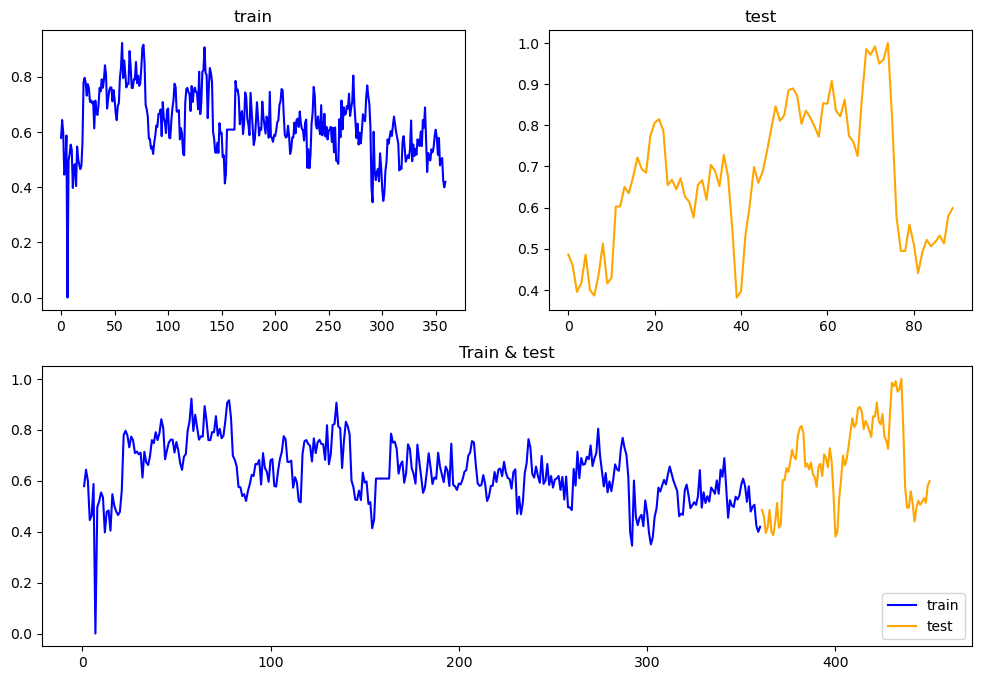

In [6]:
haha.plottraintest(train, test)

### Metode Window

Data diubah dengan lag 30       (Bebas mau pake lag berapa sebenernya, mungkin coba tuning berikutnya.)

In [9]:
# reshape into X=t and Y=t+1

t=1
trainX, trainY = haha.lag(train,t)
testX, testY = haha.lag(test,t)

In [10]:
#ubah data sehingga kompatibel dengan shape input model
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Model

Menggunakan stacked LSTM (layer pada model lebih dari 1) untuk Meningkatkan Kinerja Prediksi

Stateless guna membangun status di seluruh rangkaian pelatihan dan bahkan mempertahankan status tersebut jika diperlukan untuk membuat prediksi

In [8]:
batch_size=1

#create model
def getmodel_compile():
    model=keras.Sequential([
        
        keras.layers.LSTM(4, batch_input_shape=(batch_size, t, 1), stateful=True, return_sequences=True),                   #input and 1st memory block
        keras.layers.LSTM(8, batch_input_shape=(batch_size, t, 1), stateful=True),                                          #2nd memory block
        keras.layers.Dense(1)])                                                                                             #output (pakai 1 karena output berbentuk regresi)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=keras.metrics.RootMeanSquaredError())
    return model

In [9]:
model=getmodel_compile()

for i in range(100):
    model.fit(trainX, trainY, epochs=1, validation_data=(testX, testY), batch_size=batch_size, verbose=1)
    model.reset_states()

329/329 [==============================] - 4s 12ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 30, 4)                96        
                                                                 
 lstm_1 (LSTM)               (1, 8)                    416       
                                                                 
 dense (Dense)               (1, 1)                    9         
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.save("../../assets/statelessmodelt30.keras")

In [37]:
model=keras.models.load_model("../../assets/statelessmodelt30.keras")

In [46]:
#Lets predict and check performance metrics
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

59/59 [==============================] - 0s 5ms/step


In [47]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict).flatten()
testPredict = scaler.inverse_transform(testPredict).flatten()

df=scaler.inverse_transform(df)
testY = scaler.inverse_transform([testY]).flatten()
trainY = scaler.inverse_transform([trainY]).flatten()

In [ ]:
#flat shit
trainPredict=trainPredict.flatten

In [49]:
# Evaluation metrices RMSE and MAE
import math
print("Train data RMSE: ", math.sqrt(mean_squared_error(trainPredict,trainY)))
print("Train data MSE: ", mean_squared_error(trainY,trainPredict))
print("Train data MAE: ", mean_absolute_error(trainY,trainPredict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(testY,testPredict)))
print("Test data MSE: ", mean_squared_error(testY,testPredict))
print("Test data MAE: ", mean_absolute_error(testY,testPredict))

Train data RMSE:  4.925688723161972
Train data MSE:  24.26240939748502
Train data MAE:  3.8227542772843823
-------------------------------------------------------------------------------------
Test data RMSE:  6.233582102176611
Test data MSE:  38.85754582457658
Test data MAE:  5.0237285951661


In [50]:
print("Train data R2 score:", r2_score(trainY, trainPredict))
print("Test data R2 score:", r2_score(testY, testPredict))

Train data R2 score: 0.6629063881649316
Test data R2 score: 0.7693100738715923


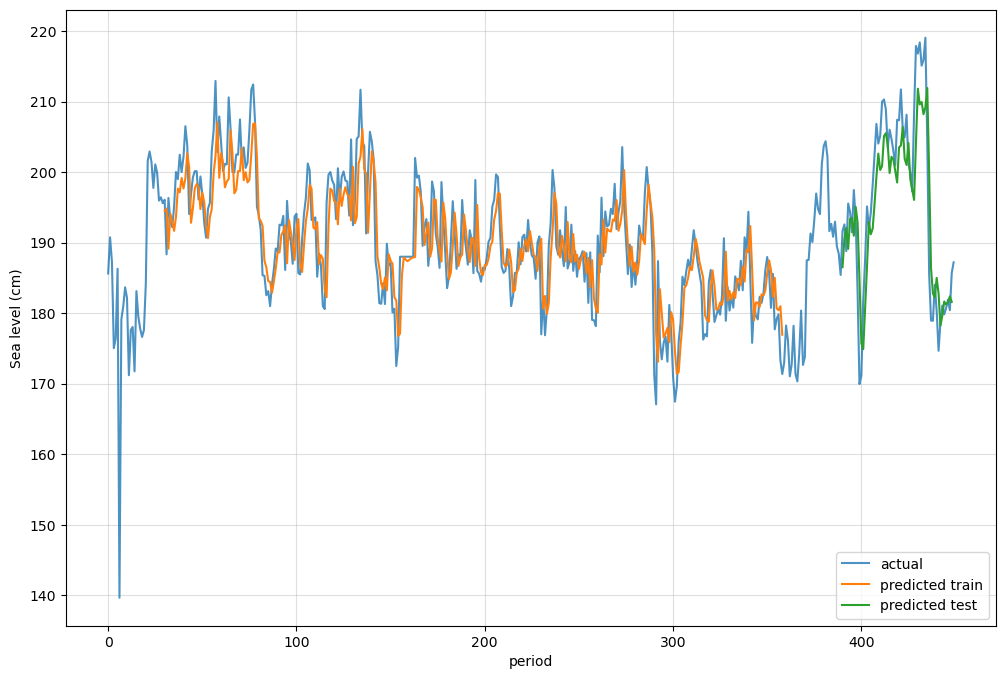

In [58]:
haha.plot_predicted(df, trainPredict.reshape(-1,1), testPredict.reshape(-1,1), t)

Predict the next 30 days

#Not finished

In [61]:

x_input=testX[len(testX)-t:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=t
i=0
pred_days = 30

while(i<pred_days):
    
    if(len(temp_input)>t):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

ValueError: cannot reshape array of size 899 into shape (1,30,1)